## ROI signal extraction

This script performs extraction and cleaning of BOLD signal from predefined brain regions. These signals are used to perform PPI GLM modeling. Signals are extracted, cleaned and stored in multidimension array for further use.

---
**Last update**: 08.04.2020 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import tempfile

from bids import BIDSLayout
from nilearn.input_data import NiftiSpheresMasker

path_root = os.environ.get('DECIDENET_PATH')
path_code = os.path.join(path_root, 'code')
if path_code not in sys.path:
    sys.path.append(path_code)
from dn_utils.behavioral_models import load_behavioral_data                    

In [2]:
# Directory for PPI analysis
path_out = os.path.join(path_root, 
                        'data/main_fmri_study/derivatives/ppi')
os.makedirs(path_out, exist_ok=True)

path_parcellations = os.path.join(path_out, 'parcellations')
path_timeries = os.path.join(path_out, 'timeseries')

# Atlases
path_300_roi = os.path.join(path_parcellations, '300_ROI_Set/ROIs_300inVol_MNI_allInfo.txt')

# Load behavioral data
path_beh = os.path.join(path_root, 'data/main_fmri_study/sourcedata/behavioral')
beh, meta = load_behavioral_data(path=path_beh)
n_subjects, n_conditions, n_trials, _ = beh.shape
n_volumes = 730

Shape of beh array: (32, 2, 110, 23)
Conditions [(0, 'rew'), (1, 'pun')]
Columns: [(0, 'block'), (1, 'block_bci'), (2, 'side'), (3, 'side_bci'), (4, 'magn_left'), (5, 'magn_right'), (6, 'response'), (7, 'rt'), (8, 'won_bool'), (9, 'won_magn'), (10, 'acc_after_trial'), (11, 'onset_iti'), (12, 'onset_iti_plan'), (13, 'onset_iti_glob'), (14, 'onset_dec'), (15, 'onset_dec_plan'), (16, 'onset_dec_glob'), (17, 'onset_isi'), (18, 'onset_isi_plan'), (19, 'onset_isi_glob'), (20, 'onset_out'), (21, 'onset_out_plan'), (22, 'onset_out_glob')]


### Query neuroimaging dataset

Using BIDSLayout object query BIDS dataset to pull out necessary files.
- `fmri_files`: list of two lists containing sorted (by subject number) paths to imaging files, first list corresponds to reward condition of PRL task and second list corresponds to punishment condition of PRL task
- `conf_files`: list of two lists containing sorted (by subject number) paths to confound files

In [3]:
path_bids = os.path.join(path_root, 'data/main_fmri_study')

layout = BIDSLayout(
    root=path_bids,
    derivatives=True,
    validate=True,
    index_metadata=False
)

fmri_filter = {
    "extension": [".nii", ".nii.gz"],
    "space": "MNI152NLin2009cAsym",
    "suffix": "bold",
    "desc": "preproc",
    "return_type": "filename"
}

conf_filter = {
    "extension": "tsv",
    "desc": "confounds",
    "return_type": "filename"
}

fmri_files, conf_files = [], []

for task_dict in [{"task": "prlrew"}, {"task": "prlpun"}]:
    fmri_filter.update(task_dict)
    conf_filter.update(task_dict)
    fmri_files.append(layout.get(**fmri_filter))
    conf_files.append(layout.get(**conf_filter))

### Load brain parcellation

Here brain parcellation is loaded. Parcellaton should be stored and formatted as csv file with (at least these) columns:

| Column Name | Description |
|:--:|----|
| `x` | x MNI coordinate for ROI center | 
| `y` | y MNI coordinate for ROI center | 
| `z` | z MNI coordinate for ROI center | 
| `radius(mm)` | sphere radius in mm |

Since `NiftiSpheresMasker` class accepts only single radius value, different maskers are created for all unique radii values (if needed). 

In [4]:
path_atlas = path_300_roi

df_atlas = pd.read_csv(path_300_roi, sep=' ')
seeds = [tuple(coords[1]) for coords in df_atlas[['x', 'y', 'z']].iterrows()]
n_rois = len(seeds)

# Dict for storing maskers for different radii values
rois = {}

for radius in df_atlas['radius(mm)'].unique():
    # Select ROIs with given radius
    roi_indices = np.flatnonzero(df_atlas['radius(mm)'] == radius)
    
    # Create masker for single radius value
    masker = NiftiSpheresMasker(
        [seeds[idx] for idx in roi_indices], 
        radius=radius,                
        mask_img=None,            
        allow_overlap=True, 
        standardize='zscore', 
        detrend=True, 
        high_pass=1/100,
        t_r=2
    )
    
    rois[radius] = {'masker': masker, 'indices': roi_indices}

### Extract and clean signal

During extraction signal is cleaned:

- high-pass filter with the 100s cut-off (0.01Hz) is applied to remove low-frequency drift
- 24 motion parameters (including first derivative and quadratic terms) are regressed out
- timecourse is grand-mean scaled (constant regressor is included)

Resulting timecourses are stored in 4-dimensional array with dimensions corresponding to subjects, tasks, volumes and roi's. Matrix shape is `n_subjects` $\times$ `n_conditions` $\times$ `n_volumes` $\times$ `n_rois`. 

In [5]:
time_series_all = np.zeros((n_subjects, n_conditions, n_volumes, n_rois))

for task_idx in range(n_conditions):
    for sub_idx in range(n_subjects):
        
        fmri_fname = fmri_files[task_idx][sub_idx]
        conf_fname = conf_files[task_idx][sub_idx]

        # Read confounds, filtering & save confounds
        conf_df = pd.read_csv(conf_fname, sep='\t')
        conf_df = conf_df.filter(regex='rot|trans')
        conf_df = conf_df.fillna(0)

        tmp_fname = 'temp'
        conf_df.to_csv(tmp_fname)

        time_series = np.zeros((n_volumes, n_rois))
        for radius in rois:
            # Get indices to insert computed timeseries into right positions
            roi_indices = rois[radius]['indices']

            # Extract timeseries
            time_series[:, roi_indices] = rois[radius]['masker'].fit_transform(
                fmri_fname,
                confounds=tmp_fname
            )
            
        time_series_all[sub_idx][task_idx] = time_series
        os.remove(tmp_fname)
        
np.save(os.path.join(path_timeries, 'time_series_clean_all'), time_series_all) 

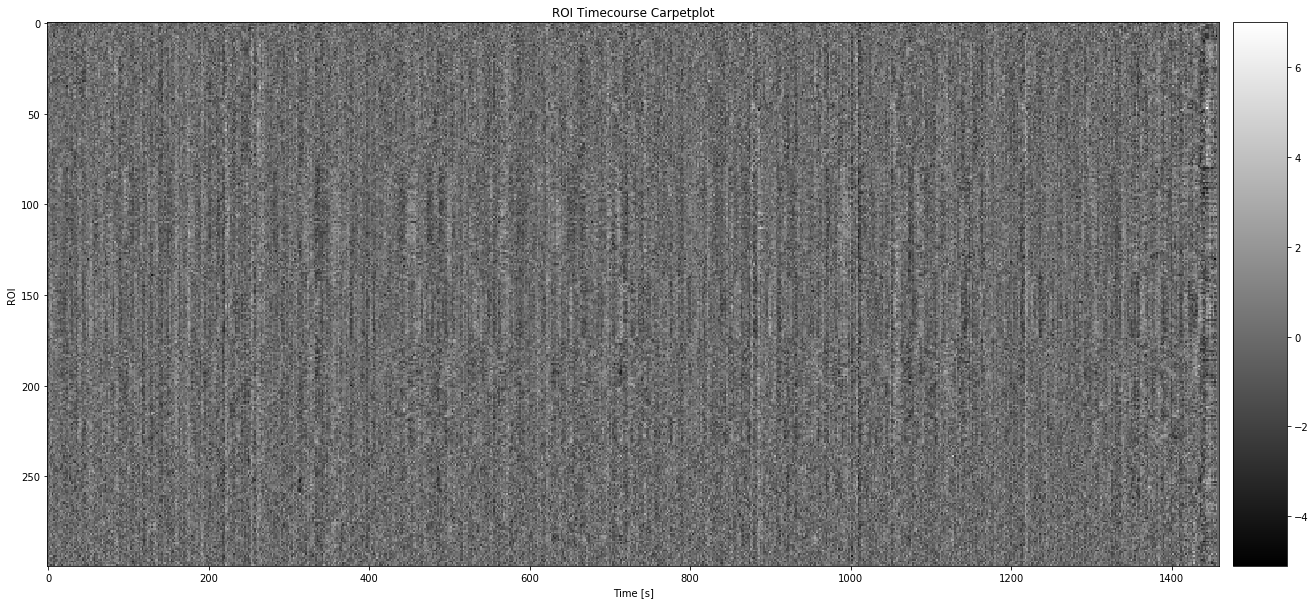

In [6]:
fig, ax = plt.subplots(figsize=(25, 10), facecolor='w')

carpet = ax.imshow(
    time_series_all[0][0].T, 
    aspect='auto',
    cmap='gray'
)

ax.set_ylabel('ROI')
ax.set_xlabel('Time [s]')
ax.set_xticklabels([f'{t:.0f}' for t in 2 * ax.get_xticks()])
ax.set_title('ROI Timecourse Carpetplot')

fig.colorbar(carpet, pad=0.01, shrink=1, aspect=10)
plt.show()

In [12]:
os.path.join(path_timeries, 'time_series_clean_all.mat')

'/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/data/main_fmri_study/derivatives/ppi/timeseries/time_series_clean_all.mat'

In [11]:
from scipy import io

io.savemat(os.path.join(path_timeries, 'time_series_clean_all.mat'), {'Y': time_series_all})